# Improved Network Intrusion Detection using Deep Learning

This notebook contains improved implementations of CNN, LSTM, and CNN-LSTM models for network intrusion detection on NSL-KDD dataset.

## Improvements:
1. **Bug Fixes**: Fixed typo in column alignment
2. **Enhanced Architectures**: Added BatchNormalization, improved regularization
3. **Class Imbalance Handling**: Implemented class weights for balanced training
4. **Advanced Training**: Early stopping, learning rate scheduling, model checkpointing
5. **Better Evaluation**: ROC-AUC curves, classification reports, enhanced visualizations
6. **Code Quality**: Better error handling and modular design


In [61]:
# Cell 1 — Setup: installs, imports, seed, GPU check, constants
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, matthews_corrcoef, roc_auc_score, 
    roc_curve, classification_report
)


In [62]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Aggressively disable XLA JIT compilation to avoid shape compatibility issues
tf.config.optimizer.set_jit(False)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_DISABLE_XLA'] = '1'
# Disable XLA for all operations
tf.config.experimental.enable_op_determinism()

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

# Mixed precision disabled to avoid shape compatibility issues
# If needed, can be enabled but requires careful handling of dtypes
# try:
#     policy = tf.keras.mixed_precision.Policy('mixed_float16')
#     tf.keras.mixed_precision.set_global_policy(policy)
#     print("Mixed precision enabled")
# except:
#     print("Mixed precision not available")
print("Using float32 precision (mixed precision disabled for stability)")
print("XLA JIT compilation disabled to avoid shape compatibility issues")


TF version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Using float32 precision (mixed precision disabled for stability)
XLA JIT compilation disabled to avoid shape compatibility issues


In [63]:
# Constants
RESULTS_DIR = "./results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Training parameters
EPOCHS = 50
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2
PATIENCE = 10  # For early stopping

sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)
print("Setup complete.")


Setup complete.


In [64]:
# Cell 2 — NSL-KDD loading and preprocessing
# Using direct file paths - update these to match your dataset location
train_fp = "/kaggle/input/nslkdd/KDDTrain+.txt"
test_fp = "/kaggle/input/nslkdd/KDDTest+.txt"

# Alternative paths for local execution
if not os.path.exists(train_fp):
    train_fp = "./KDDTrain+.txt"
    test_fp = "./KDDTest+.txt"

print("Using NSL-KDD files:")
print(f"  Train: {train_fp}")
print(f"  Test: {test_fp}")


Using NSL-KDD files:
  Train: /kaggle/input/nslkdd/KDDTrain+.txt
  Test: /kaggle/input/nslkdd/KDDTest+.txt


In [65]:
# Read the data (NSL-KDD has no headers)
try:
    df_train = pd.read_csv(train_fp, header=None)
    df_test = pd.read_csv(test_fp, header=None)
    print("Data loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the dataset files are in the correct location.")
    raise


Data loaded successfully!


In [66]:
# Add column names based on NSL-KDD documentation
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'difficulty'
]

df_train.columns = columns
df_test.columns = columns

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print("\nFirst few rows:")
print(df_train.head())


Train shape: (125973, 43)
Test shape: (22544, 43)

First few rows:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1    

Label distribution - Train:
label
0    67343
1    58630
Name: count, dtype: int64

Train class ratio (Normal:Attack): 1.15

Label distribution - Test:
label
1    12833
0     9711
Name: count, dtype: int64

Test class ratio (Normal:Attack): 0.76


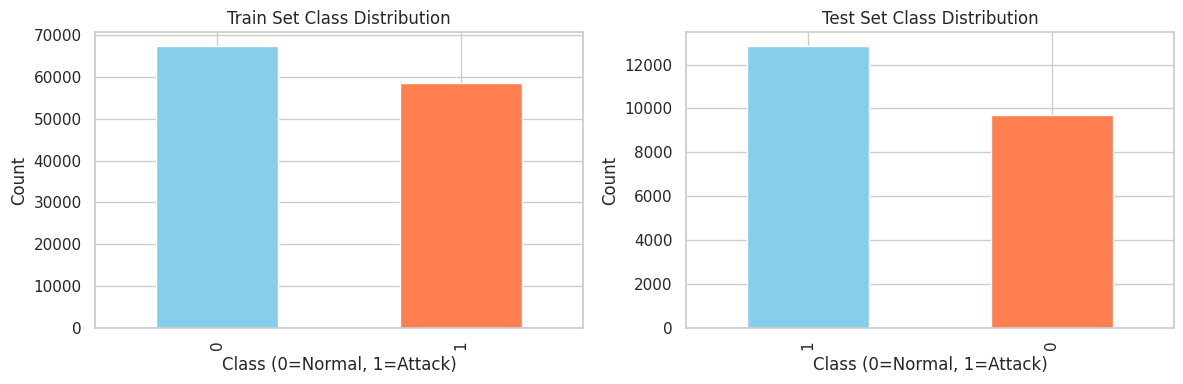

In [67]:
# Convert to binary labels (normal = 0, attack = 1)
df_train['label'] = df_train['attack_type'].apply(lambda x: 0 if x == 'normal' else 1)
df_test['label'] = df_test['attack_type'].apply(lambda x: 0 if x == 'normal' else 1)

print("Label distribution - Train:")
train_dist = df_train['label'].value_counts()
print(train_dist)
print(f"\nTrain class ratio (Normal:Attack): {train_dist[0]/train_dist[1]:.2f}")

print("\nLabel distribution - Test:")
test_dist = df_test['label'].value_counts()
print(test_dist)
print(f"\nTest class ratio (Normal:Attack): {test_dist[0]/test_dist[1]:.2f}")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
train_dist.plot(kind='bar', ax=axes[0], title='Train Set Class Distribution', color=['skyblue', 'coral'])
axes[0].set_xlabel('Class (0=Normal, 1=Attack)')
axes[0].set_ylabel('Count')
test_dist.plot(kind='bar', ax=axes[1], title='Test Set Class Distribution', color=['skyblue', 'coral'])
axes[1].set_xlabel('Class (0=Normal, 1=Attack)')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/class_distribution.png', dpi=150)
plt.show()

# Drop unnecessary columns
df_train = df_train.drop(['attack_type', 'difficulty'], axis=1)
df_test = df_test.drop(['attack_type', 'difficulty'], axis=1)


In [68]:
# Handle categorical columns (protocol_type, service, flag)
categorical_columns = ['protocol_type', 'service', 'flag']

# One-hot encode categorical variables
df_train = pd.get_dummies(df_train, columns=categorical_columns, prefix=categorical_columns)
df_test = pd.get_dummies(df_test, columns=categorical_columns, prefix=categorical_columns)

# Align columns (some services might be missing in test set)
# FIXED BUG: Changed df_test.colum to df_test.columns
train_cols = df_train.columns
test_cols = df_test.columns

# Add missing columns to test set
missing_cols = set(train_cols) - set(test_cols)
if missing_cols:
    print(f"Adding {len(missing_cols)} missing columns to test set")
    for col in missing_cols:
        if col != 'label':
            df_test[col] = 0

# Remove extra columns from test set
extra_cols = set(test_cols) - set(train_cols)
if extra_cols:
    print(f"Removing {len(extra_cols)} extra columns from test set")
    df_test = df_test.drop(columns=list(extra_cols))

# Reorder test columns to match train
df_test = df_test[train_cols]

print(f"\nAfter preprocessing:")
print(f"  Train shape: {df_train.shape}")
print(f"  Test shape: {df_test.shape}")
print(f"  Number of features: {len(train_cols) - 1}")


Adding 6 missing columns to test set

After preprocessing:
  Train shape: (125973, 123)
  Test shape: (22544, 123)
  Number of features: 122


In [69]:
# Prepare features and labels
feature_cols = [col for col in df_train.columns if col != 'label']

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[feature_cols].astype(float))
X_test = scaler.transform(df_test[feature_cols].astype(float))

# Calculate class weights for imbalanced dataset
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(df_train['label']),
    y=df_train['label']
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weight_dict}")

# Reshape for CNN/LSTM (samples, timesteps, features)
timesteps = X_train.shape[1]
X_train = X_train.reshape((-1, timesteps, 1))
X_test = X_test.reshape((-1, timesteps, 1))

y_train = df_train['label'].values
y_test = df_test['label'].values

print(f"\nFinal shapes:")
print(f"  X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"  Timesteps: {timesteps}")


Class weights: {0: 0.9353087923020953, 1: 1.0743049633293535}

Final shapes:
  X_train: (125973, 122, 1), X_test: (22544, 122, 1)
  y_train: (125973,), y_test: (22544,)
  Timesteps: 122


In [70]:
# Cell 3 — Improved Model definitions
# Based on original architectures with safe enhancements

def build_cnn_improved(input_shape):
    """Enhanced CNN model - based on original with regularization"""
    model = keras.Sequential([
        layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 3, activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ])
    return model

def build_lstm_improved(input_shape):
    """Enhanced LSTM model - based on original with bidirectional"""
    model = keras.Sequential([
        layers.Bidirectional(layers.LSTM(64), input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dense(2, activation='softmax')
    ])
    return model

def build_cnn_lstm_improved(input_shape):
    """Enhanced CNN-LSTM hybrid - based on original architecture"""
    model = keras.Sequential([
        layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.LSTM(64),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dense(2, activation='softmax')
    ])
    return model

print("Model architectures defined successfully!")


Model architectures defined successfully!


In [71]:
# Cell 4 — Enhanced Training and Evaluation Functions

def create_callbacks(model_name):
    """Create callbacks for training"""
    callback_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=f'{RESULTS_DIR}/{model_name}_best.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        callbacks.CSVLogger(f'{RESULTS_DIR}/{model_name}_training.log')
    ]
    return callback_list

def train_model_improved(model, name, class_weight=None):
    """Enhanced training function with callbacks and class weights"""
    # Disable XLA JIT compilation to avoid shape compatibility issues
    tf.config.optimizer.set_jit(False)
    
    # Use Adam optimizer with learning rate scheduling
    initial_lr = 0.001
    optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
    
    # Use only accuracy metric to avoid shape compatibility issues with precision/recall
    # Run eagerly to bypass graph compilation issues
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        run_eagerly=False  # Set to True if still having issues
    )
    
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print(f"{'='*60}")
    print(f"Model summary:")
    model.summary()
    
    callback_list = create_callbacks(name)
    
    # Test model with a small batch first to catch shape errors early
    try:
        # Test forward pass
        test_input = X_train[:1]
        _ = model(test_input, training=False)
        print("Model forward pass test successful!")
    except Exception as e:
        print(f"ERROR: Model forward pass failed: {e}")
        print("This indicates a shape mismatch in the model architecture.")
        raise
    
    history = model.fit(
        X_train, y_train,
        validation_split=VALIDATION_SPLIT,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weight,
        callbacks=callback_list,
        verbose=1
    )
    
    return model, history

def evaluate_model_improved(model, name, history=None):
    """Enhanced evaluation with ROC curves and detailed metrics"""
    y_pred_proba = model.predict(X_test, verbose=0, batch_size=BATCH_SIZE)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_pred_proba_class1 = y_pred_proba[:, 1]  # Probability of attack class
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'mcc': matthews_corrcoef(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_class1)
    }
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(16, 5))
    
    # Plot 1: Confusion Matrix
    ax1 = plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Attack'], 
                yticklabels=['Normal', 'Attack'],
                ax=ax1)
    ax1.set_title(f'Confusion Matrix - {name}')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # Plot 2: ROC Curve
    ax2 = plt.subplot(1, 3, 2)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_class1)
    ax2.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {metrics["roc_auc"]:.4f})')
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'ROC Curve - {name}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Training History (if available)
    if history is not None:
        ax3 = plt.subplot(1, 3, 3)
        ax3.plot(history.history['loss'], label='Train Loss', linewidth=2)
        ax3.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Loss')
        ax3.set_title(f'Training History - {name}')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/{name}_evaluation.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    # Print detailed results
    print(f"\n{name} Results:")
    print("-" * 60)
    for metric, value in metrics.items():
        print(f"  {metric.upper():15s}: {value:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, 
                                target_names=['Normal', 'Attack'],
                                digits=4))
    
    return metrics, history


In [72]:
# Cell 5 — Run experiments with improved models
models = {
    'CNN_Improved': build_cnn_improved((timesteps, 1)),
    'LSTM_Improved': build_lstm_improved((timesteps, 1)),
    'CNN_LSTM_Improved': build_cnn_lstm_improved((timesteps, 1))
}

print("Starting model training with improvements...")
print(f"Training parameters:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Validation split: {VALIDATION_SPLIT}")
print(f"  Early stopping patience: {PATIENCE}")
print(f"  Class weights: {class_weight_dict}")

results = []
histories = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Processing {name}")
    print(f"{'='*60}")
    
    trained_model, history = train_model_improved(model, name, class_weight=class_weight_dict)
    metrics, _ = evaluate_model_improved(trained_model, name, history)
    metrics['model'] = name
    results.append(metrics)
    histories[name] = history
    
    print(f"\n{name} training completed!")
    print(f"{'='*60}\n")


Starting model training with improvements...
Training parameters:
  Epochs: 50
  Batch size: 128
  Validation split: 0.2
  Early stopping patience: 10
  Class weights: {0: 0.9353087923020953, 1: 1.0743049633293535}

Processing CNN_Improved

Training CNN_Improved
Model summary:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_25 (Conv1D)              │ (None, 120, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 58, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,346 (130.26 KB)

 Trainable params: 33,346 (130.26 KB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1764752165.951963      47 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model forward pass test successful!
Epoch 1/50


2025-12-03 08:56:06.846182: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8348 - loss: 0.4238

2025-12-03 08:56:17.114275: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 1: val_loss improved from inf to 0.16227, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8350 - loss: 0.4235 - val_accuracy: 0.9586 - val_loss: 0.1623 - learning_rate: 0.0010
Epoch 2/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9581 - loss: 0.1651
Epoch 2: val_loss improved from 0.16227 to 0.13733, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9581 - loss: 0.1651 - val_accuracy: 0.9628 - val_loss: 0.1373 - learning_rate: 0.0010
Epoch 3/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9643 - loss: 0.1392
Epoch 3: val_loss improved from 0.13733 to 0.11960, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9643 - loss: 0.1392 - val_accuracy: 0.9680 - val_loss: 0.1196 - learning_rate: 0.0010
Epoch 4/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9683 - loss: 0.1240
Epoch 4: val_loss improved from 0.11960 to 0.10665, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9683 - loss: 0.1240 - val_accuracy: 0.9715 - val_loss: 0.1067 - learning_rate: 0.0010
Epoch 5/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9715 - loss: 0.1117
Epoch 5: val_loss improved from 0.10665 to 0.09990, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9715 - loss: 0.1117 - val_accuracy: 0.9725 - val_loss: 0.0999 - learning_rate: 0.0010
Epoch 6/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9733 - loss: 0.1026
Epoch 6: val_loss improved from 0.09990 to 0.09828, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9733 - loss: 0.1026 - val_accuracy: 0.9717 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 7/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9742 - loss: 0.0943
Epoch 7: val_loss improved from 0.09828 to 0.07694, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9742 - loss: 0.0943 - val_accuracy: 0.9775 - val_loss: 0.0769 - learning_rate: 0.0010
Epoch 8/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9766 - loss: 0.0845
Epoch 8: val_loss did not improve from 0.07694
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9766 - loss: 0.0845 - val_accuracy: 0.9756 - val_loss: 0.0793 - learning_rate: 0.0010
Epoch 9/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9778 - loss: 0.0798
Epoch 9: val_loss improved from 0.07694 to 0.07583, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9778 - loss: 0.0798 - val_accuracy: 0.9752 - val_loss: 0.0758 - learning_rate: 0.0010
Epoch 10/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9796 - loss: 0.0725
Epoch 10: val_loss improved from 0.07583 to 0.07323, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9796 - loss: 0.0725 - val_accuracy: 0.9764 - val_loss: 0.0732 - learning_rate: 0.0010
Epoch 11/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9807 - loss: 0.0694
Epoch 11: val_loss improved from 0.07323 to 0.07009, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9807 - loss: 0.0694 - val_accuracy: 0.9760 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 12/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9827 - loss: 0.0645
Epoch 12: val_loss improved from 0.07009 to 0.06498, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9827 - loss: 0.0645 - val_accuracy: 0.9777 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 13/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9834 - loss: 0.0623
Epoch 13: val_loss improved from 0.06498 to 0.05492, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9834 - loss: 0.0623 - val_accuracy: 0.9828 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 14/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9842 - loss: 0.0576
Epoch 14: val_loss did not improve from 0.05492
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9842 - loss: 0.0576 - val_accuracy: 0.9820 - val_loss: 0.0564 - learning_rate: 0.0010
Epoch 15/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9850 - loss: 0.0554
Epoch 15: val_loss improved from 0.05492 to 0.05146, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9850 - loss: 0.0554 - val_accuracy: 0.9834 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 16/50
781/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9848 - loss: 0.0548
Epoch 16: val_loss did not improve from 0.05146
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9848 - loss: 0.0548 - val_accuracy: 0.9789 - val_loss: 0.0627 - learning_rate: 0.0010
Epoch 17/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9851 - loss: 0.0534
Epoch 17: val_loss improved from 0.05146 to 0.05000, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9851 - loss: 0.0534 - val_accuracy: 0.9836 - val_loss: 0.0500 - learning_rate: 0.0010
Epoch 18/50
781/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9855 - loss: 0.0512
Epoch 18: val_loss did not improve from 0.05000
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9855 - loss: 0.0512 - val_accuracy: 0.9786 - val_loss: 0.0615 - learning_rate: 0.0010
Epoch 19/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9859 - loss: 0.0502
Epoch 19: val_loss improved from 0.05000 to 0.04783, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9859 - loss: 0.0502 - val_accuracy: 0.9839 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 20/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9871 - loss: 0.0474
Epoch 20: val_loss did not improve from 0.04783
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9871 - loss: 0.0474 - val_accuracy: 0.9827 - val_loss: 0.0493 - learning_rate: 0.0010
Epoch 21/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9867 - loss: 0.0466
Epoch 21: val_loss did not improve from 0.04783
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9867 - loss: 0.0466 - val_accuracy: 0.9784 - val_loss: 0.0594 - learning_rate: 0.0010
Epoch 22/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9867 - loss: 0.0464
Epoch 22: val_loss did not improve from 0.04783
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9867 - loss: 0.0464 - val_accuracy: 0.9837 - val_loss: 0.0505 - learning_rate: 0.0010
Epoch 23/50
783/788 ━━━━━━━━━━━

788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9877 - loss: 0.0442 - val_accuracy: 0.9830 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 24/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9872 - loss: 0.0446
Epoch 24: val_loss improved from 0.04776 to 0.04002, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9872 - loss: 0.0446 - val_accuracy: 0.9864 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 25/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9879 - loss: 0.0427
Epoch 25: val_loss did not improve from 0.04002
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9879 - loss: 0.0427 - val_accuracy: 0.9810 - val_loss: 0.0556 - learning_rate: 0.0010
Epoch 26/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9877 - loss: 0.0428
Epoch 26: val_loss did not improve from 0.04002
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9877 - loss: 0.0428 - val_accuracy: 0.9854 - val_loss: 0.0444 - learning_rate: 0.0010
Epoch 27/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9880 - loss: 0.0413
Epoch 27: val_loss did not improve from 0.04002
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9880 - loss: 0.0413 - val_accuracy: 0.9857 - val_loss: 0.0415 - learning_rate: 0.0010
Epoch 28/50
788/788 ━━━━━━━━━━━

788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9882 - loss: 0.0406 - val_accuracy: 0.9887 - val_loss: 0.0363 - learning_rate: 0.0010
Epoch 30/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9886 - loss: 0.0391
Epoch 30: val_loss did not improve from 0.03629
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9886 - loss: 0.0391 - val_accuracy: 0.9880 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 31/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9895 - loss: 0.0382
Epoch 31: val_loss improved from 0.03629 to 0.03292, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9895 - loss: 0.0382 - val_accuracy: 0.9896 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 32/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9892 - loss: 0.0377
Epoch 32: val_loss improved from 0.03292 to 0.03270, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9892 - loss: 0.0377 - val_accuracy: 0.9902 - val_loss: 0.0327 - learning_rate: 0.0010
Epoch 33/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9891 - loss: 0.0380
Epoch 33: val_loss improved from 0.03270 to 0.03055, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9891 - loss: 0.0380 - val_accuracy: 0.9906 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 34/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9899 - loss: 0.0369
Epoch 34: val_loss did not improve from 0.03055
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9899 - loss: 0.0369 - val_accuracy: 0.9908 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 35/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9889 - loss: 0.0374
Epoch 35: val_loss did not improve from 0.03055
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9889 - loss: 0.0374 - val_accuracy: 0.9906 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 36/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9893 - loss: 0.0362
Epoch 36: val_loss did not improve from 0.03055
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9893 - loss: 0.0362 - val_accuracy: 0.9908 - val_loss: 0.0308 - learning_rate: 0.0010
Epoch 37/50
784/788 ━━━━━━━━━━━

788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9914 - loss: 0.0318 - val_accuracy: 0.9923 - val_loss: 0.0275 - learning_rate: 5.0000e-04
Epoch 40/50
781/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9916 - loss: 0.0307
Epoch 40: val_loss did not improve from 0.02748
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9916 - loss: 0.0307 - val_accuracy: 0.9929 - val_loss: 0.0319 - learning_rate: 5.0000e-04
Epoch 41/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9919 - loss: 0.0299
Epoch 41: val_loss improved from 0.02748 to 0.02704, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9919 - loss: 0.0299 - val_accuracy: 0.9929 - val_loss: 0.0270 - learning_rate: 5.0000e-04
Epoch 42/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9919 - loss: 0.0298
Epoch 42: val_loss did not improve from 0.02704
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9919 - loss: 0.0298 - val_accuracy: 0.9911 - val_loss: 0.0302 - learning_rate: 5.0000e-04
Epoch 43/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9915 - loss: 0.0307
Epoch 43: val_loss did not improve from 0.02704
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9915 - loss: 0.0307 - val_accuracy: 0.9933 - val_loss: 0.0274 - learning_rate: 5.0000e-04
Epoch 44/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9921 - loss: 0.0295
Epoch 44: val_loss did not improve from 0.02704
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9921 - loss: 0.0295 - val_accuracy: 0.9936 - val_loss: 0.0275 - learning_rate: 5.0000e-04
Epoch 45/50
784

788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9921 - loss: 0.0293 - val_accuracy: 0.9940 - val_loss: 0.0265 - learning_rate: 5.0000e-04
Epoch 47/50
781/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9923 - loss: 0.0288
Epoch 47: val_loss improved from 0.02655 to 0.02452, saving model to ./results/CNN_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9923 - loss: 0.0288 - val_accuracy: 0.9939 - val_loss: 0.0245 - learning_rate: 5.0000e-04
Epoch 48/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9925 - loss: 0.0283
Epoch 48: val_loss did not improve from 0.02452
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9925 - loss: 0.0283 - val_accuracy: 0.9940 - val_loss: 0.0271 - learning_rate: 5.0000e-04
Epoch 49/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9922 - loss: 0.0284
Epoch 49: val_loss did not improve from 0.02452
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9922 - loss: 0.0284 - val_accuracy: 0.9929 - val_loss: 0.0278 - learning_rate: 5.0000e-04
Epoch 50/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9916 - loss: 0.0288
Epoch 50: val_loss did not improve from 0.02452
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9916 - loss: 0.0288 - val_accuracy: 0.9941 - val_loss: 0.0260 - learning_rate: 5.0000e-04
Restoring model

2025-12-03 09:00:56.018729: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



CNN_Improved Results:
------------------------------------------------------------
  ACCURACY       : 0.7683
  PRECISION      : 0.9275
  RECALL         : 0.6432
  F1             : 0.7596
  MCC            : 0.5843
  ROC_AUC        : 0.9531

Classification Report:
              precision    recall  f1-score   support

      Normal     0.6644    0.9336    0.7763      9711
      Attack     0.9275    0.6432    0.7596     12833

    accuracy                         0.7683     22544
   macro avg     0.7960    0.7884    0.7680     22544
weighted avg     0.8142    0.7683    0.7668     22544


CNN_Improved training completed!


Processing LSTM_Improved

Training LSTM_Improved
Model summary:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_14                │ (None, 128)            │        33,792 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,986 (148.38 KB)

 Trainable params: 37,986 (148.38 KB)

 Non-trainable params: 0 (0.00 B)

Model forward pass test successful!
Epoch 1/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9269 - loss: 0.2709

2025-12-03 09:01:10.050171: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 1: val_loss improved from inf to 0.10502, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9269 - loss: 0.2705 - val_accuracy: 0.9655 - val_loss: 0.1050 - learning_rate: 0.0010
Epoch 2/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9699 - loss: 0.0922
Epoch 2: val_loss improved from 0.10502 to 0.07171, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9699 - loss: 0.0922 - val_accuracy: 0.9774 - val_loss: 0.0717 - learning_rate: 0.0010
Epoch 3/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9758 - loss: 0.0708
Epoch 3: val_loss improved from 0.07171 to 0.05430, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9758 - loss: 0.0708 - val_accuracy: 0.9834 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 4/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9809 - loss: 0.0569
Epoch 4: val_loss did not improve from 0.05430
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9809 - loss: 0.0569 - val_accuracy: 0.9807 - val_loss: 0.0560 - learning_rate: 0.0010
Epoch 5/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9813 - loss: 0.0535
Epoch 5: val_loss improved from 0.05430 to 0.04566, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9813 - loss: 0.0535 - val_accuracy: 0.9865 - val_loss: 0.0457 - learning_rate: 0.0010
Epoch 6/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9833 - loss: 0.0465
Epoch 6: val_loss did not improve from 0.04566
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9833 - loss: 0.0465 - val_accuracy: 0.9780 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 7/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9804 - loss: 0.0549
Epoch 7: val_loss improved from 0.04566 to 0.04456, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9804 - loss: 0.0549 - val_accuracy: 0.9841 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 8/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9848 - loss: 0.0456
Epoch 8: val_loss improved from 0.04456 to 0.03454, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9848 - loss: 0.0456 - val_accuracy: 0.9894 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 9/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9869 - loss: 0.0391
Epoch 9: val_loss did not improve from 0.03454
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9869 - loss: 0.0391 - val_accuracy: 0.9879 - val_loss: 0.0385 - learning_rate: 0.0010
Epoch 10/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9871 - loss: 0.0366
Epoch 10: val_loss did not improve from 0.03454
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9871 - loss: 0.0366 - val_accuracy: 0.9878 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 11/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9883 - loss: 0.0353
Epoch 11: val_loss improved from 0.03454 to 0.03212, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9883 - loss: 0.0353 - val_accuracy: 0.9897 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 12/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9883 - loss: 0.0341
Epoch 12: val_loss improved from 0.03212 to 0.03089, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9883 - loss: 0.0341 - val_accuracy: 0.9906 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 13/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9896 - loss: 0.0310
Epoch 13: val_loss improved from 0.03089 to 0.03022, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9896 - loss: 0.0310 - val_accuracy: 0.9908 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 14/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9912 - loss: 0.0300
Epoch 14: val_loss did not improve from 0.03022
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9912 - loss: 0.0300 - val_accuracy: 0.9838 - val_loss: 0.0444 - learning_rate: 0.0010
Epoch 15/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9887 - loss: 0.0341
Epoch 15: val_loss improved from 0.03022 to 0.02600, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9888 - loss: 0.0340 - val_accuracy: 0.9919 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 16/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9918 - loss: 0.0260
Epoch 16: val_loss did not improve from 0.02600
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9918 - loss: 0.0260 - val_accuracy: 0.9922 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 17/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9907 - loss: 0.0285
Epoch 17: val_loss did not improve from 0.02600
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9907 - loss: 0.0285 - val_accuracy: 0.9919 - val_loss: 0.0286 - learning_rate: 0.0010
Epoch 18/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9903 - loss: 0.0292
Epoch 18: val_loss improved from 0.02600 to 0.02409, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9903 - loss: 0.0292 - val_accuracy: 0.9928 - val_loss: 0.0241 - learning_rate: 0.0010
Epoch 19/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9924 - loss: 0.0249
Epoch 19: val_loss did not improve from 0.02409
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9924 - loss: 0.0249 - val_accuracy: 0.9917 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 20/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9923 - loss: 0.0237
Epoch 20: val_loss did not improve from 0.02409
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9923 - loss: 0.0237 - val_accuracy: 0.9917 - val_loss: 0.0259 - learning_rate: 0.0010
Epoch 21/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9919 - loss: 0.0248
Epoch 21: val_loss did not improve from 0.02409
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9919 - loss: 0.0248 - val_accuracy: 0.9920 - val_loss: 0.0249 - learning_rate: 0.0010
Epoch 22/50
787/788 

788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9928 - loss: 0.0231 - val_accuracy: 0.9927 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 24/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9934 - loss: 0.0214
Epoch 24: val_loss improved from 0.02270 to 0.02205, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9934 - loss: 0.0214 - val_accuracy: 0.9932 - val_loss: 0.0221 - learning_rate: 0.0010
Epoch 25/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9935 - loss: 0.0216
Epoch 25: val_loss improved from 0.02205 to 0.01976, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9935 - loss: 0.0216 - val_accuracy: 0.9944 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 26/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9916 - loss: 0.0274
Epoch 26: val_loss improved from 0.01976 to 0.01887, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9916 - loss: 0.0274 - val_accuracy: 0.9954 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 27/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9943 - loss: 0.0195
Epoch 27: val_loss improved from 0.01887 to 0.01881, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9943 - loss: 0.0195 - val_accuracy: 0.9950 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 28/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9939 - loss: 0.0203
Epoch 28: val_loss did not improve from 0.01881
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9939 - loss: 0.0203 - val_accuracy: 0.9935 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 29/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9920 - loss: 0.0269
Epoch 29: val_loss improved from 0.01881 to 0.01827, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9921 - loss: 0.0269 - val_accuracy: 0.9953 - val_loss: 0.0183 - learning_rate: 0.0010
Epoch 30/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9934 - loss: 0.0222
Epoch 30: val_loss did not improve from 0.01827
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9934 - loss: 0.0222 - val_accuracy: 0.9864 - val_loss: 0.0484 - learning_rate: 0.0010
Epoch 31/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9684 - loss: 0.0990
Epoch 31: val_loss did not improve from 0.01827
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9685 - loss: 0.0988 - val_accuracy: 0.9924 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 32/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9920 - loss: 0.0265
Epoch 32: val_loss did not improve from 0.01827
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9920 - loss: 0.0265 - val_accuracy: 0.9940 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 33/50
784/788 

788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9954 - loss: 0.0164 - val_accuracy: 0.9952 - val_loss: 0.0159 - learning_rate: 5.0000e-04
Epoch 36/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9956 - loss: 0.0157
Epoch 36: val_loss did not improve from 0.01590
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9956 - loss: 0.0157 - val_accuracy: 0.9954 - val_loss: 0.0165 - learning_rate: 5.0000e-04
Epoch 37/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9959 - loss: 0.0148
Epoch 37: val_loss improved from 0.01590 to 0.01554, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9959 - loss: 0.0148 - val_accuracy: 0.9959 - val_loss: 0.0155 - learning_rate: 5.0000e-04
Epoch 38/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9961 - loss: 0.0139
Epoch 38: val_loss did not improve from 0.01554
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9961 - loss: 0.0139 - val_accuracy: 0.9957 - val_loss: 0.0162 - learning_rate: 5.0000e-04
Epoch 39/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9959 - loss: 0.0137
Epoch 39: val_loss improved from 0.01554 to 0.01526, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9959 - loss: 0.0137 - val_accuracy: 0.9960 - val_loss: 0.0153 - learning_rate: 5.0000e-04
Epoch 40/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9963 - loss: 0.0134
Epoch 40: val_loss did not improve from 0.01526
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9963 - loss: 0.0134 - val_accuracy: 0.9929 - val_loss: 0.0189 - learning_rate: 5.0000e-04
Epoch 41/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9943 - loss: 0.0161
Epoch 41: val_loss did not improve from 0.01526
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9943 - loss: 0.0161 - val_accuracy: 0.9942 - val_loss: 0.0180 - learning_rate: 5.0000e-04
Epoch 42/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9952 - loss: 0.0147
Epoch 42: val_loss did not improve from 0.01526
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9952 - loss: 0.0147 - val_accuracy: 0.9961 - val_loss: 0.0154 - learning_rate: 5.0000e-04
Epoc

788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9965 - loss: 0.0125 - val_accuracy: 0.9961 - val_loss: 0.0146 - learning_rate: 5.0000e-04
Epoch 44/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9963 - loss: 0.0123
Epoch 44: val_loss did not improve from 0.01463
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9963 - loss: 0.0123 - val_accuracy: 0.9959 - val_loss: 0.0147 - learning_rate: 5.0000e-04
Epoch 45/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9963 - loss: 0.0132
Epoch 45: val_loss improved from 0.01463 to 0.01407, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9963 - loss: 0.0132 - val_accuracy: 0.9963 - val_loss: 0.0141 - learning_rate: 5.0000e-04
Epoch 46/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9964 - loss: 0.0121
Epoch 46: val_loss did not improve from 0.01407
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9964 - loss: 0.0121 - val_accuracy: 0.9962 - val_loss: 0.0150 - learning_rate: 5.0000e-04
Epoch 47/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9966 - loss: 0.0117
Epoch 47: val_loss did not improve from 0.01407
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9966 - loss: 0.0117 - val_accuracy: 0.9959 - val_loss: 0.0142 - learning_rate: 5.0000e-04
Epoch 48/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9969 - loss: 0.0111
Epoch 48: val_loss improved from 0.01407 to 0.01358, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9969 - loss: 0.0111 - val_accuracy: 0.9960 - val_loss: 0.0136 - learning_rate: 5.0000e-04
Epoch 49/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9968 - loss: 0.0118
Epoch 49: val_loss improved from 0.01358 to 0.01355, saving model to ./results/LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9968 - loss: 0.0118 - val_accuracy: 0.9962 - val_loss: 0.0135 - learning_rate: 5.0000e-04
Epoch 50/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9970 - loss: 0.0106
Epoch 50: val_loss did not improve from 0.01355
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9970 - loss: 0.0106 - val_accuracy: 0.9960 - val_loss: 0.0147 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 49.


2025-12-03 09:10:00.644813: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



LSTM_Improved Results:
------------------------------------------------------------
  ACCURACY       : 0.7889
  PRECISION      : 0.9260
  RECALL         : 0.6838
  F1             : 0.7867
  MCC            : 0.6135
  ROC_AUC        : 0.8982

Classification Report:
              precision    recall  f1-score   support

      Normal     0.6895    0.9278    0.7911      9711
      Attack     0.9260    0.6838    0.7867     12833

    accuracy                         0.7889     22544
   macro avg     0.8077    0.8058    0.7889     22544
weighted avg     0.8241    0.7889    0.7886     22544


LSTM_Improved training completed!


Processing CNN_LSTM_Improved

Training CNN_LSTM_Improved
Model summary:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 120, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,426 (138.38 KB)

 Trainable params: 35,426 (138.38 KB)

 Non-trainable params: 0 (0.00 B)

Model forward pass test successful!
Epoch 1/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8861 - loss: 0.3208

2025-12-03 09:10:11.210119: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 1: val_loss improved from inf to 0.11088, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8865 - loss: 0.3198 - val_accuracy: 0.9699 - val_loss: 0.1109 - learning_rate: 0.0010
Epoch 2/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9703 - loss: 0.1029
Epoch 2: val_loss improved from 0.11088 to 0.08448, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9703 - loss: 0.1028 - val_accuracy: 0.9754 - val_loss: 0.0845 - learning_rate: 0.0010
Epoch 3/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9826 - loss: 0.0554
Epoch 3: val_loss improved from 0.08448 to 0.03844, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9826 - loss: 0.0553 - val_accuracy: 0.9873 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 4/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9841 - loss: 0.0475
Epoch 4: val_loss improved from 0.03844 to 0.03353, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9841 - loss: 0.0475 - val_accuracy: 0.9888 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 5/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9870 - loss: 0.0395
Epoch 5: val_loss improved from 0.03353 to 0.02917, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9870 - loss: 0.0395 - val_accuracy: 0.9895 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 6/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9876 - loss: 0.0381
Epoch 6: val_loss did not improve from 0.02917
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9876 - loss: 0.0381 - val_accuracy: 0.9902 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 7/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9900 - loss: 0.0316
Epoch 7: val_loss improved from 0.02917 to 0.02669, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9900 - loss: 0.0316 - val_accuracy: 0.9912 - val_loss: 0.0267 - learning_rate: 0.0010
Epoch 8/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9903 - loss: 0.0304
Epoch 8: val_loss did not improve from 0.02669
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9903 - loss: 0.0304 - val_accuracy: 0.9903 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 9/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9900 - loss: 0.0309
Epoch 9: val_loss did not improve from 0.02669
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9900 - loss: 0.0309 - val_accuracy: 0.9906 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 10/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9912 - loss: 0.0294
Epoch 10: val_loss improved from 0.02669 to 0.02412, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9912 - loss: 0.0294 - val_accuracy: 0.9929 - val_loss: 0.0241 - learning_rate: 0.0010
Epoch 11/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9918 - loss: 0.0272
Epoch 11: val_loss improved from 0.02412 to 0.02381, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9918 - loss: 0.0272 - val_accuracy: 0.9928 - val_loss: 0.0238 - learning_rate: 0.0010
Epoch 12/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9922 - loss: 0.0249
Epoch 12: val_loss did not improve from 0.02381
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9922 - loss: 0.0249 - val_accuracy: 0.9925 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 13/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9921 - loss: 0.0263
Epoch 13: val_loss did not improve from 0.02381
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9921 - loss: 0.0263 - val_accuracy: 0.9923 - val_loss: 0.0259 - learning_rate: 0.0010
Epoch 14/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9922 - loss: 0.0241
Epoch 14: val_loss improved from 0.02381 to 0.02083, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9922 - loss: 0.0241 - val_accuracy: 0.9936 - val_loss: 0.0208 - learning_rate: 0.0010
Epoch 15/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9930 - loss: 0.0222
Epoch 15: val_loss did not improve from 0.02083
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9930 - loss: 0.0222 - val_accuracy: 0.9930 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 16/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9922 - loss: 0.0240
Epoch 16: val_loss did not improve from 0.02083
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9922 - loss: 0.0240 - val_accuracy: 0.9907 - val_loss: 0.0300 - learning_rate: 0.0010
Epoch 17/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9935 - loss: 0.0211
Epoch 17: val_loss improved from 0.02083 to 0.02016, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9935 - loss: 0.0211 - val_accuracy: 0.9939 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 18/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9934 - loss: 0.0201
Epoch 18: val_loss did not improve from 0.02016
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9934 - loss: 0.0201 - val_accuracy: 0.9932 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 19/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9932 - loss: 0.0213
Epoch 19: val_loss improved from 0.02016 to 0.01941, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9932 - loss: 0.0213 - val_accuracy: 0.9940 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 20/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9936 - loss: 0.0205
Epoch 20: val_loss did not improve from 0.01941
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9936 - loss: 0.0205 - val_accuracy: 0.9929 - val_loss: 0.0210 - learning_rate: 0.0010
Epoch 21/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9940 - loss: 0.0188
Epoch 21: val_loss did not improve from 0.01941
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9940 - loss: 0.0188 - val_accuracy: 0.9936 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 22/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9938 - loss: 0.0196
Epoch 22: val_loss did not improve from 0.01941
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9938 - loss: 0.0196 - val_accuracy: 0.9935 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 23/50
785/788 ━━━━━━━━━━━

788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9938 - loss: 0.0192 - val_accuracy: 0.9940 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 24/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9947 - loss: 0.0165
Epoch 24: val_loss did not improve from 0.01901
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9947 - loss: 0.0165 - val_accuracy: 0.9941 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 25/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9938 - loss: 0.0194
Epoch 25: val_loss did not improve from 0.01901
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9938 - loss: 0.0194 - val_accuracy: 0.9933 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 26/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9938 - loss: 0.0205
Epoch 26: val_loss improved from 0.01901 to 0.01738, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9938 - loss: 0.0205 - val_accuracy: 0.9947 - val_loss: 0.0174 - learning_rate: 0.0010
Epoch 27/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9954 - loss: 0.0147
Epoch 27: val_loss did not improve from 0.01738
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9954 - loss: 0.0147 - val_accuracy: 0.9921 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 28/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9934 - loss: 0.0188
Epoch 28: val_loss improved from 0.01738 to 0.01688, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9934 - loss: 0.0188 - val_accuracy: 0.9941 - val_loss: 0.0169 - learning_rate: 0.0010
Epoch 29/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9947 - loss: 0.0157
Epoch 29: val_loss did not improve from 0.01688
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9947 - loss: 0.0157 - val_accuracy: 0.9929 - val_loss: 0.0210 - learning_rate: 0.0010
Epoch 30/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9948 - loss: 0.0159
Epoch 30: val_loss improved from 0.01688 to 0.01680, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9948 - loss: 0.0159 - val_accuracy: 0.9947 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 31/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9958 - loss: 0.0134
Epoch 31: val_loss did not improve from 0.01680
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9958 - loss: 0.0134 - val_accuracy: 0.9950 - val_loss: 0.0176 - learning_rate: 0.0010
Epoch 32/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9949 - loss: 0.0156
Epoch 32: val_loss did not improve from 0.01680
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9949 - loss: 0.0156 - val_accuracy: 0.9938 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 33/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9955 - loss: 0.0149
Epoch 33: val_loss improved from 0.01680 to 0.01546, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9955 - loss: 0.0149 - val_accuracy: 0.9952 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 34/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9951 - loss: 0.0155
Epoch 34: val_loss did not improve from 0.01546
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9951 - loss: 0.0155 - val_accuracy: 0.9951 - val_loss: 0.0177 - learning_rate: 0.0010
Epoch 35/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9938 - loss: 0.0195
Epoch 35: val_loss did not improve from 0.01546
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9938 - loss: 0.0194 - val_accuracy: 0.9906 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 36/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9942 - loss: 0.0173
Epoch 36: val_loss did not improve from 0.01546
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9942 - loss: 0.0173 - val_accuracy: 0.9915 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 37/50
787/788 ━━━━━━━━━━━

788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9963 - loss: 0.0116 - val_accuracy: 0.9958 - val_loss: 0.0142 - learning_rate: 5.0000e-04
Epoch 40/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0107
Epoch 40: val_loss did not improve from 0.01418
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9970 - loss: 0.0107 - val_accuracy: 0.9958 - val_loss: 0.0142 - learning_rate: 5.0000e-04
Epoch 41/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9969 - loss: 0.0104
Epoch 41: val_loss improved from 0.01418 to 0.01392, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9969 - loss: 0.0104 - val_accuracy: 0.9959 - val_loss: 0.0139 - learning_rate: 5.0000e-04
Epoch 42/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9965 - loss: 0.0106
Epoch 42: val_loss improved from 0.01392 to 0.01327, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9965 - loss: 0.0106 - val_accuracy: 0.9956 - val_loss: 0.0133 - learning_rate: 5.0000e-04
Epoch 43/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9968 - loss: 0.0099
Epoch 43: val_loss did not improve from 0.01327
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9968 - loss: 0.0099 - val_accuracy: 0.9957 - val_loss: 0.0134 - learning_rate: 5.0000e-04
Epoch 44/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0097
Epoch 44: val_loss did not improve from 0.01327
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9970 - loss: 0.0097 - val_accuracy: 0.9956 - val_loss: 0.0135 - learning_rate: 5.0000e-04
Epoch 45/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9966 - loss: 0.0098
Epoch 45: val_loss improved from 0.01327 to 0.01291, saving model to ./results/CNN_LSTM_Improved_best.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9966 - loss: 0.0097 - val_accuracy: 0.9963 - val_loss: 0.0129 - learning_rate: 5.0000e-04
Epoch 46/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9968 - loss: 0.0102
Epoch 46: val_loss did not improve from 0.01291
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9968 - loss: 0.0102 - val_accuracy: 0.9957 - val_loss: 0.0149 - learning_rate: 5.0000e-04
Epoch 47/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9967 - loss: 0.0096
Epoch 47: val_loss did not improve from 0.01291
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9967 - loss: 0.0096 - val_accuracy: 0.9957 - val_loss: 0.0136 - learning_rate: 5.0000e-04
Epoch 48/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9968 - loss: 0.0099
Epoch 48: val_loss did not improve from 0.01291
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9968 - loss: 0.0099 - val_accuracy: 0.9952 - val_loss: 0.0165 - learning_rate: 5.0000e-04
Epoch 49/50
785

788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9970 - loss: 0.0090 - val_accuracy: 0.9962 - val_loss: 0.0126 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 50.


2025-12-03 09:15:49.398994: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



CNN_LSTM_Improved Results:
------------------------------------------------------------
  ACCURACY       : 0.7366
  PRECISION      : 0.9213
  RECALL         : 0.5875
  F1             : 0.7175
  MCC            : 0.5367
  ROC_AUC        : 0.9245

Classification Report:
              precision    recall  f1-score   support

      Normal     0.6314    0.9337    0.7534      9711
      Attack     0.9213    0.5875    0.7175     12833

    accuracy                         0.7366     22544
   macro avg     0.7764    0.7606    0.7354     22544
weighted avg     0.7964    0.7366    0.7330     22544


CNN_LSTM_Improved training completed!




FINAL RESULTS SUMMARY

 accuracy  precision   recall       f1      mcc  roc_auc             model
 0.768275   0.927520 0.643186 0.759617 0.584303 0.953069      CNN_Improved
 0.788902   0.926024 0.683784 0.786678 0.613543 0.898250     LSTM_Improved
 0.736648   0.921310 0.587548 0.717514 0.536743 0.924461 CNN_LSTM_Improved

Results saved to: ./results/nsl_kdd_results_improved.csv


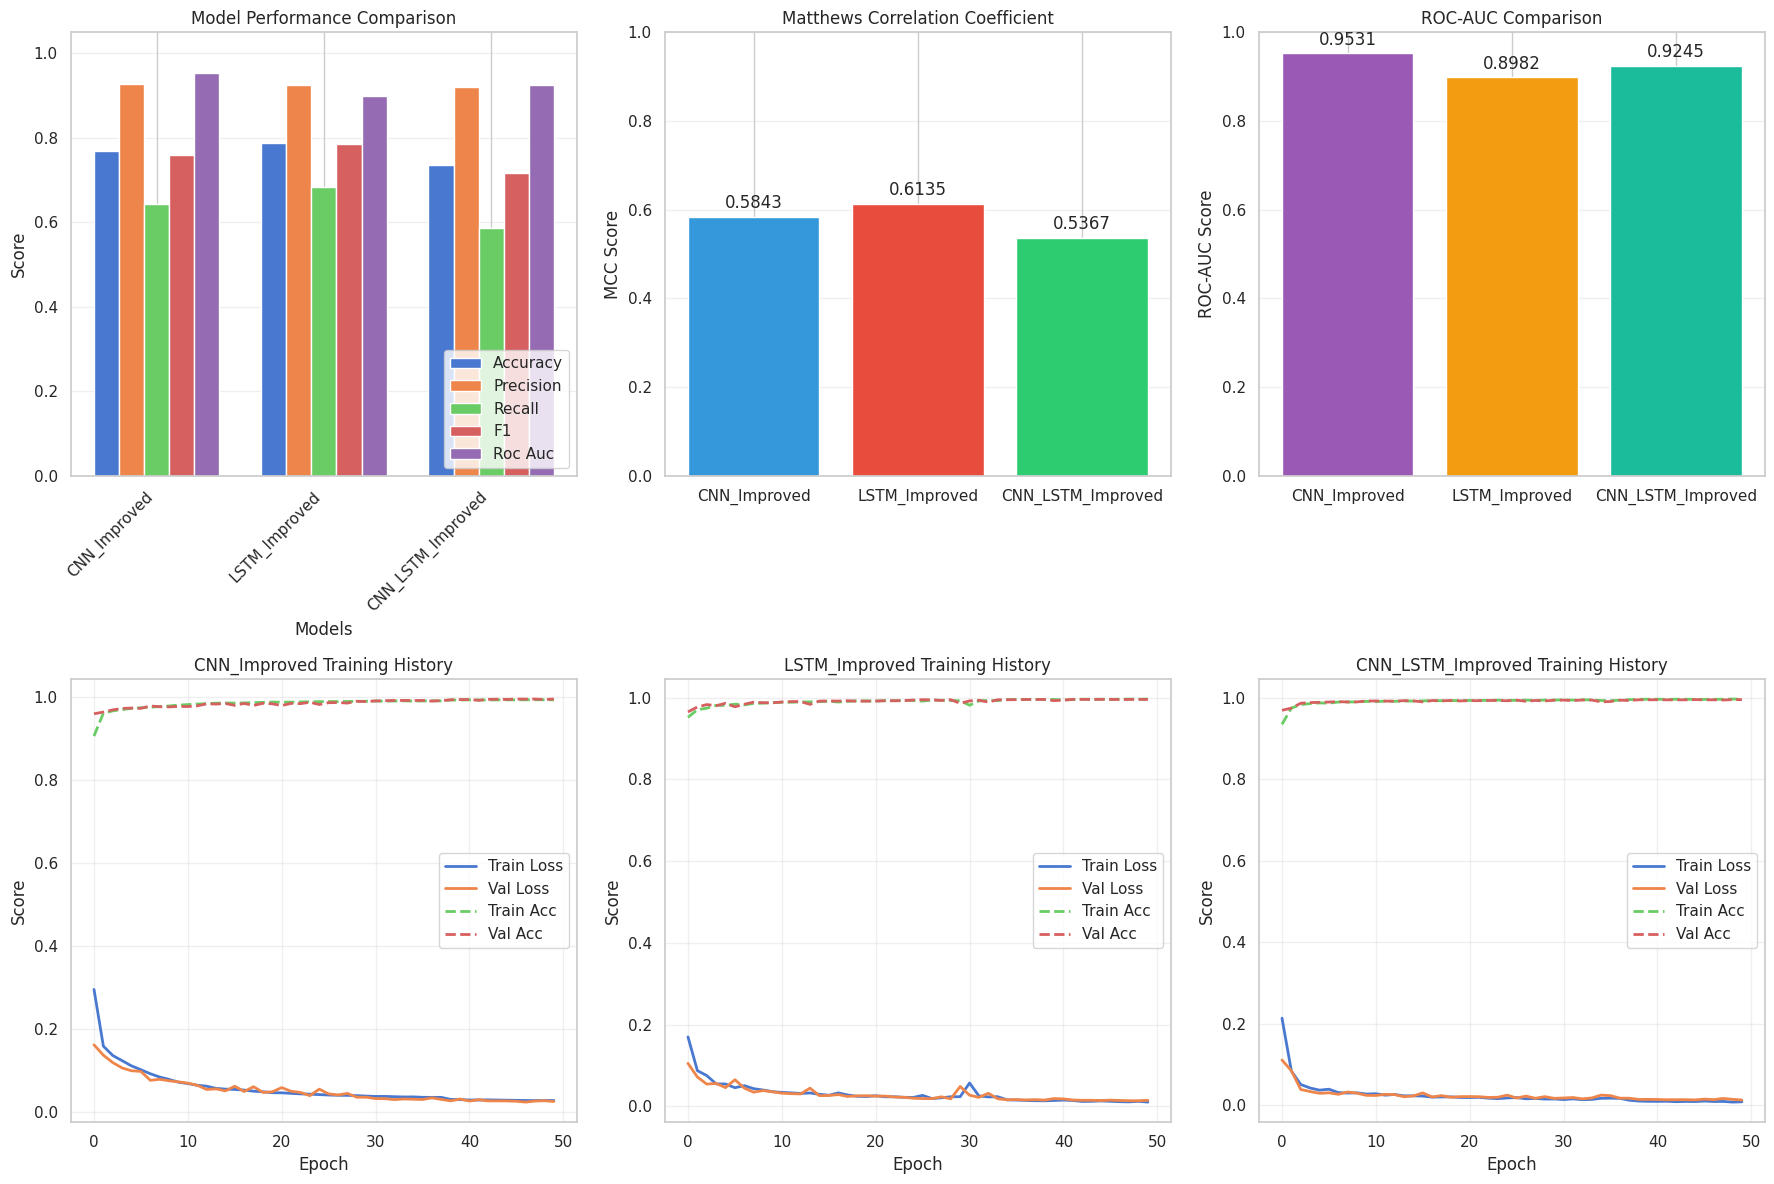


BEST MODEL: LSTM_Improved
accuracy          0.788902
precision         0.926024
recall            0.683784
f1                0.786678
mcc               0.613543
roc_auc            0.89825
model        LSTM_Improved


In [73]:
# Cell 6 — Comprehensive Results Analysis and Visualization

print(f"\n{'='*60}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*60}\n")

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv(f'{RESULTS_DIR}/nsl_kdd_results_improved.csv', index=False)
print(f"\nResults saved to: {RESULTS_DIR}/nsl_kdd_results_improved.csv")

# Create comprehensive comparison plots
fig = plt.figure(figsize=(18, 12))

# Plot 1: Metrics Comparison Bar Chart
ax1 = plt.subplot(2, 3, 1)
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    offset = (i - len(metrics_to_plot)/2) * width + width/2
    ax1.bar(x + offset, results_df[metric], width, label=metric.replace('_', ' ').title())

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['model'], rotation=45, ha='right')
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: MCC Comparison
ax2 = plt.subplot(2, 3, 2)
bars = ax2.bar(results_df['model'], results_df['mcc'], color=['#3498db', '#e74c3c', '#2ecc71'])
ax2.set_ylabel('MCC Score')
ax2.set_title('Matthews Correlation Coefficient')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars, results_df['mcc'])):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

# Plot 3: ROC-AUC Comparison
ax3 = plt.subplot(2, 3, 3)
bars = ax3.bar(results_df['model'], results_df['roc_auc'], color=['#9b59b6', '#f39c12', '#1abc9c'])
ax3.set_ylabel('ROC-AUC Score')
ax3.set_title('ROC-AUC Comparison')
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars, results_df['roc_auc'])):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

# Plot 4-6: Training History Comparison
for idx, (name, history) in enumerate(histories.items(), start=4):
    ax = plt.subplot(2, 3, idx)
    ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax.plot(history.history['accuracy'], label='Train Acc', linewidth=2, linestyle='--')
    ax.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2, linestyle='--')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.set_title(f'{name} Training History')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/comprehensive_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best model
best_model_idx = results_df['f1'].idxmax()
best_model = results_df.loc[best_model_idx, 'model']
print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model}")
print(f"{'='*60}")
print(results_df.loc[best_model_idx].to_string())
print(f"{'='*60}")


In [74]:
# Additional Analysis: Feature Importance and Model Comparison Table

print("\nDetailed Model Comparison:")
print("="*80)
comparison_table = results_df.set_index('model').T
print(comparison_table.to_string())
print("="*80)

# Save comparison table
comparison_table.to_csv(f'{RESULTS_DIR}/detailed_comparison.csv')

# Create a summary report
with open(f'{RESULTS_DIR}/summary_report.txt', 'w') as f:
    f.write("Network Intrusion Detection - Improved Model Results\n")
    f.write("="*80 + "\n\n")
    f.write(f"Dataset: NSL-KDD\n")
    f.write(f"Training samples: {len(y_train)}\n")
    f.write(f"Test samples: {len(y_test)}\n")
    f.write(f"Features: {timesteps}\n\n")
    f.write("Model Performance:\n")
    f.write("-"*80 + "\n")
    f.write(results_df.to_string(index=False))
    f.write("\n\n")
    f.write(f"Best Model (by F1-Score): {best_model}\n")
    f.write("="*80 + "\n")

print(f"\nSummary report saved to: {RESULTS_DIR}/summary_report.txt")
print("\nAll results and visualizations have been saved successfully!")



Detailed Model Comparison:
model      CNN_Improved  LSTM_Improved  CNN_LSTM_Improved
accuracy       0.768275       0.788902           0.736648
precision      0.927520       0.926024           0.921310
recall         0.643186       0.683784           0.587548
f1             0.759617       0.786678           0.717514
mcc            0.584303       0.613543           0.536743
roc_auc        0.953069       0.898250           0.924461

Summary report saved to: ./results/summary_report.txt

All results and visualizations have been saved successfully!
